In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from menelaus.data_drift.cdbd import CDBD
from menelaus.data_drift.hdddm import HDDDM
from menelaus.data_drift import PCACD
from menelaus.data_drift import KdqTreeStreaming, KdqTreeBatch
from menelaus.data_drift import NNDVI
from menelaus.datasets import make_example_batch_data, fetch_circle_data

example_data = make_example_batch_data()

print(example_data.head())

   year             a           b            c              d         e  \
0  2007   5036.441154  198.936685  6995.029198  133187.697950  0.402750   
1  2007  10773.027107  179.260652  3467.970499   52174.100900  1.019491   
2  2007   6173.596856  199.775829  4921.472906  101848.950792 -2.248839   
3  2007  13208.612929  182.222072  9638.632797   92442.165726 -0.045599   
4  2007   2719.272009  213.028454  5501.439179   79155.846985 -1.602719   

          f              g             h             i            j  cat  \
0 -1.339692   90453.457231   8819.761759   5398.861764  1059.835492    2   
1 -1.145258   72629.507052  10137.233887   7009.344647  1552.888540    2   
2  1.903668   54839.516587   9603.709193  10579.518133   856.266082    1   
3  1.106212   84447.758390  12511.305427   5618.433039   451.926312    2   
4 -1.368130  168769.099013  16034.259622   6214.909756   853.582074    1   

   confidence  drift  
0    0.591243  False  
1    0.196090  False  
2    0.504019  False  


# Hellinger Distance Drift Detection Method (HDDDM)

In [2]:
# This section details how to setup, run, and produce plots for HDDDM, using both
# numeric and categorical data. Drift occurs in 2009, 2015, 2018, and 2021.
# Drift in 2018 persists through 2021.
# 
# 
# Plots include:
# 
# - A line plot visualizing test statistics for detection of drift 
# 
# - A heatmap visualizing "where" drift is occuring, showing features for each
#   year's test batch with the greatest Hellinger distance from the reference
#   batch.

## Setup ##

# Set up reference and test batches, using 2007 as reference year
# -2 indexing removes columns "drift" and "confidence"
reference = example_data[example_data.year == 2007].iloc[:, 1:-2]
all_test = example_data[example_data.year != 2007]

#  Setup HDDDM
np.random.seed(1)
hdddm = HDDDM(subsets=8)

# Store epsilons per feature for heatmap
years = all_test.year.unique()
heatmap_data = pd.DataFrame(columns = years)

# Store drift for test statistic plot
detected_drift = []

# Run HDDDM
hdddm.set_reference(reference)
for year, subset_data in example_data[example_data.year != 2007].groupby("year"):
    hdddm.update(subset_data.iloc[:, 1:-2])
    heatmap_data[year] = hdddm.feature_epsilons
    detected_drift.append(hdddm.drift_state)


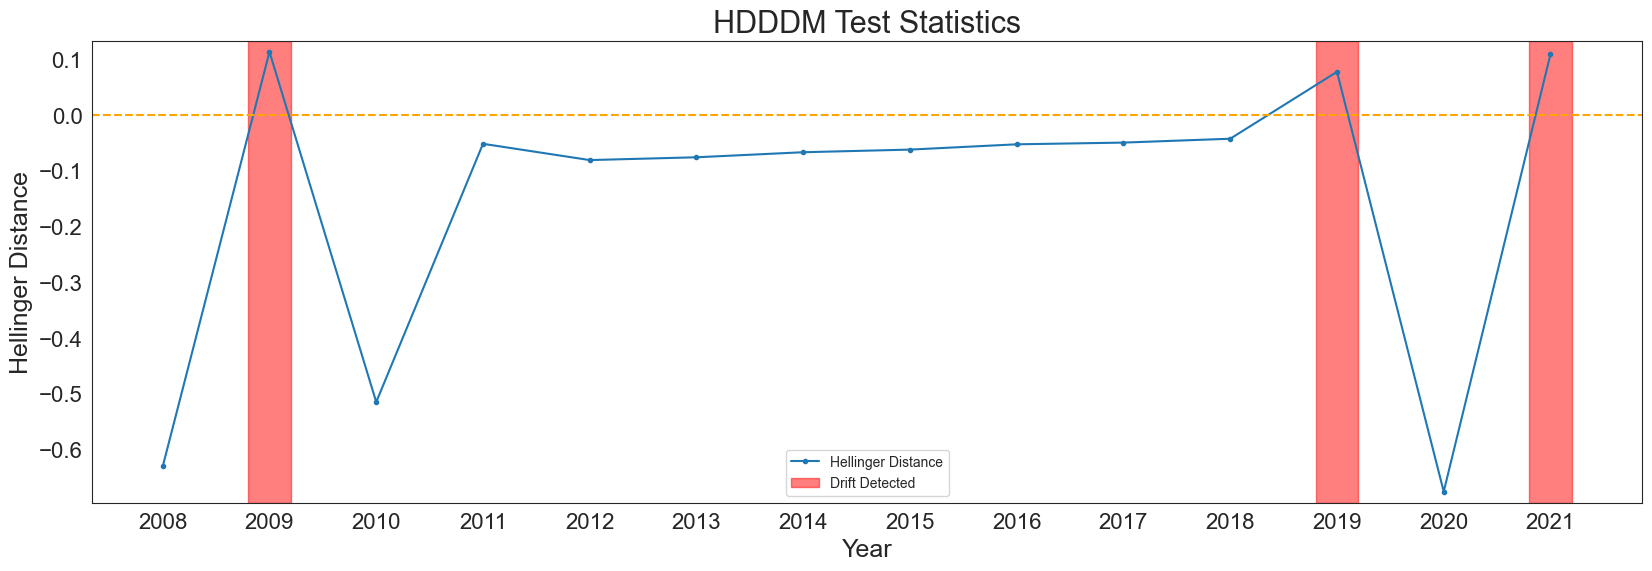

In [3]:
## Plot Line Graph ##
h_distances = [
    ep - th for ep, th in zip(hdddm.epsilon_values.values(), hdddm.thresholds.values())
]

# Plot Hellinger Distance against Year, along with detected drift
plot_data = pd.DataFrame(
    {"Year": years, "Hellinger Distance": h_distances, "Detected Drift": detected_drift}
)
sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot(
    "Year", "Hellinger Distance", data=plot_data, label="Hellinger Distance", marker="."
)
plt.grid(False, axis="x")
plt.xticks(years, fontsize=16)
plt.yticks(fontsize=16)
plt.title("HDDDM Test Statistics", fontsize=22)
plt.ylabel("Hellinger Distance", fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylim([min(h_distances) - 0.02, max(h_distances) + 0.02])
for _, t in enumerate(plot_data.loc[plot_data["Detected Drift"] == "drift"]["Year"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )
plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")

plt.show()
# plt.savefig("example_HDDDM_test_statistics.png")

# HDDDM identifies drifts in 2009, 2010, 2019, 2021. These drifts involve
# a change in mean or variance. Drift in 2010 is likely identified as the
# distribution returns to state prior to 2009 drift. Drift in 2015, a change in
# correlation, is undetected. Drift in 2018 is detected one year late.


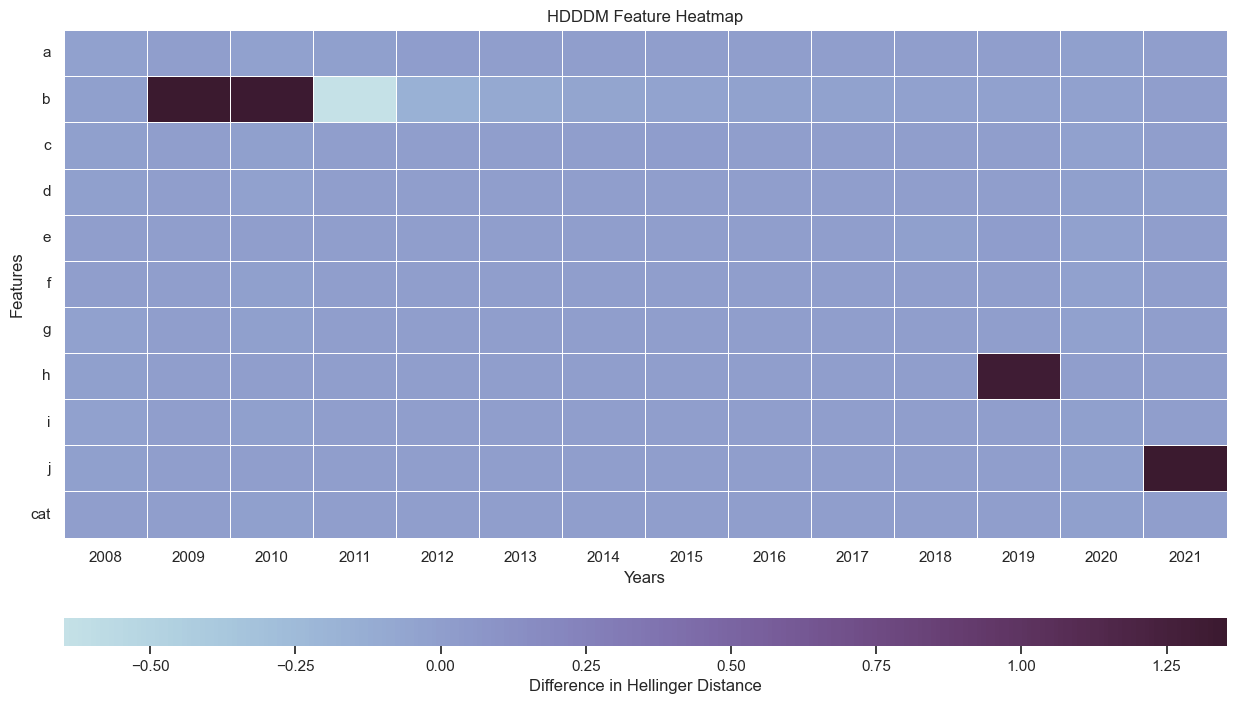

In [4]:
## Plot Heatmap ##
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (15, 8)})

# Setup plot

# Setup plot
grid_kws = {"height_ratios": (0.9, 0.05), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start=0.8, rot=-0.5, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    xticklabels=heatmap_data.columns,
    yticklabels=["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "cat"],
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)
ax.set_title('HDDDM Feature Heatmap')
ax.set(xlabel="Years", ylabel="Features")
ax.collections[0].colorbar.set_label("Difference in Hellinger Distance")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()
# plt.savefig("example_HDDDM_feature_heatmap.png")

# - Drift in feature B is detected in 2009 and 2010 (as it reverts to normal).
# 
# - Drift in feature H is detected in 2019. Drift in feature J is detected in 2021.
# 
# - The undetected drift occurs in 2015 in the correlations between features E and F.